## Read me

1. ``pip install tensorflow``

2. Put data files in
``cancer-net/pnet/_database``
which can be downloaded from Google Drive [here](https://drive.google.com/uc?id=17nssbdUylkyQY1ebtxsIw5UzTAd0zxWb&export=download).

3. To install pysr, use ``conda install -c conda-forge pysr``, then run ``python -c 'import pysr; pysr.install()'``



In [1]:
import os
import importlib
import tensorflow as tf
import pandas as pd
import numpy as np

import pysr
from cancernet.pnet import config_path
from cancernet.pnet.config_path import PROSTATE_LOG_PATH, POSTATE_PARAMS_PATH
from cancernet.pnet.model.model_factory import get_model
from cancernet.pnet.model.nn import Model
from cancernet.pnet.model.builders.builders_utils import get_map_from_layer, get_layer_maps

from cancernet.pnet.data.data_access import Data
from cancernet.pnet.data.prostate_paper.data_reader import ProstateDataPaper, load_data_type
from cancernet.pnet.data.prostate_paper import data_reader
from cancernet.pnet.data.pathways.reactome import ReactomeNetwork


from sklearn.metrics import roc_auc_score, roc_curve, auc, average_precision_score, f1_score, accuracy_score, \
    precision_score, recall_score

enable_run_pysr = False

2022-10-12 21:51:18.539276: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-12 21:51:18.703698: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-10-12 21:51:18.709717: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /cm/shared/apps/slurm/current/lib64:/mnt/sw/nix/store/f0ycdncw8dw4wlicnzm74lgv9c51rlg4-openblas-

In [2]:
params_file = '.onsplit_average_reg_10_tanh_large_testing'
params_file_full = "cancernet.pnet.train.params.P1000.pnet" + params_file
params = importlib.import_module(params_file_full)

In [3]:
# manipulate gene list
old_genes = pd.read_csv(os.path.join(
    config_path.DATA_PATH,
    'genes',
    params.models[0]['params']['model_params']['data_params']['params']['selected_genes'],
))
print("input", len(old_genes))

# load pyg dataset
from cancernet import PnetDataSet
import torch, torch_geometric.transforms as T, torch.nn.functional as F
pyg_dataset = PnetDataSet(
    root=os.path.join("data", "prostate"),
    name="prostate_graph_humanbase",
    # files={'graph_file': "global.geneSymbol.gz"},
    edge_tol=0.5,
    pre_transform=T.Compose(
        [T.GCNNorm(add_self_loops=False), T.ToSparseTensor(remove_edge_index=False)]
    ),
)
print("pyg", len(pyg_dataset.node_index))

# match pyg and pnet
new_genes = sorted([x for x in old_genes['genes'] if x in pyg_dataset.node_index])
print("after match", len(new_genes))
new_genes = pd.DataFrame({'genes': new_genes}, index=np.arange(len(new_genes)))
new_genes.to_csv(
    os.path.join(
        config_path.DATA_PATH,
        'genes',
        params.models[0]['params']['model_params']['data_params']['params']['selected_genes'] + "matched_pyg.csv",
        ),
    index=False
)

input 14665
pyg 9054
after match 9054


# Manual Tuning of P-Net

This tuning is essential for Tensorflow P-Net to work with PyTorch P-Net architecture.

Reduced hidden layers (from n=5 to n=2) have the 'surprising' effect of a much better performance


In [4]:
# manually adjusted P-net model params
n_hidden_layers = 2
params.models[0]['params']['model_params']['n_hidden_layers'] = n_hidden_layers
params.models[0]['params']['model_params']['w_reg'] = [0.001] * (n_hidden_layers+1)
params.models[0]['params']['model_params']['w_reg_outcomes'] = [0.001] * (n_hidden_layers+1)
params.models[0]['params']['model_params']['dropout'] = [0.5]+[0.1] * (n_hidden_layers+1)
params.models[0]['params']['model_params']['loss_weights'] = [2] * (n_hidden_layers-6) + [2, 7, 20, 54, 148, 400]
# new input genes
params.models[0]['params']['model_params']['data_params']['params']['selected_genes'] += "matched_pyg.csv"
# change molecular data type order to match PyG dataset
params.models[0]['params']['model_params']['data_params']['params']['data_type'] = \
 ['mut_important', 'cnv_amp', 'cnv_del']

In [5]:
data = Data(**params.data[0])

x_train, x_validate_, x_test_, y_train, y_validate_, y_test_, info_train, info_validate_, info_test_, cols = data.get_train_validate_test()
np.save('x_train.npy', x_train)
np.save('y_train.npy', y_train)
np.save('x_test_.npy', x_test_)
np.save('y_test_.npy', y_test_)

print(x_train.shape)

/mnt/ceph/users/zzhang/cancer-net/cancernet/pnet/data/prostate_paper/data_reader.py:69: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  x = x.loc[:, intersect]
/mnt/ceph/users/zzhang/cancer-net/cancernet/pnet/data/prostate_paper/data_reader.py:69: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  x = x.loc[:, intersect]
/mnt/ceph/users/zzhang/cancer-net/cancernet/pnet/data/prostate_paper/data_reader.py:69: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  x = x.loc[:, intersect]


(807, 27162)


In [6]:
# gene names should have been sorted to allow reproducibility
cols.levels[0]

Index(['A1CF', 'AAAS', 'AACS', 'AADAC', 'AADACL2', 'AAGAB', 'AAMP', 'AANAT',
       'AARSD1', 'AASDH',
       ...
       'ZSWIM4', 'ZSWIM5', 'ZSWIM6', 'ZW10', 'ZWILCH', 'ZXDA', 'ZXDB',
       'ZYG11B', 'ZYX', 'ZZZ3'],
      dtype='object', length=9054)

In [7]:
# model inherits a sklearn BaseEstimator
model = Model(**params.models[0]['params'])
model.get_params()

{'model_params': {'use_bias': True,
  'w_reg': [0.001, 0.001, 0.001],
  'w_reg_outcomes': [0.001, 0.001, 0.001],
  'dropout': [0.5, 0.1, 0.1, 0.1],
  'loss_weights': [2, 7, 20, 54, 148, 400],
  'optimizer': 'Adam',
  'activation': 'tanh',
  'data_params': {'id': 'ALL',
   'type': 'prostate_paper',
   'params': {'data_type': ['mut_important', 'cnv_amp', 'cnv_del'],
    'drop_AR': False,
    'cnv_levels': 3,
    'mut_binary': True,
    'balanced_data': False,
    'combine_type': 'union',
    'use_coding_genes_only': True,
    'selected_genes': 'tcga_prostate_expressed_genes_and_cancer_genes.csvmatched_pyg.csv',
    'training_split': 0}},
  'add_unk_genes': False,
  'shuffle_genes': False,
  'kernel_initializer': 'lecun_uniform',
  'n_hidden_layers': 2,
  'attention': False,
  'dropout_testing': False},
 'fitting_params': {'samples_per_epoch': 10,
  'select_best_model': False,
  'monitor': 'val_o6_f1',
  'verbose': 2,
  'epoch': 300,
  'shuffle': True,
  'batch_size': 50,
  'save_name': '

In [8]:
ret = model.build_fn(**model.model_params)
pnet_mod, feature_names, reactome_map = ret

{'id': 'ALL', 'type': 'prostate_paper', 'params': {'data_type': ['mut_important', 'cnv_amp', 'cnv_del'], 'drop_AR': False, 'cnv_levels': 3, 'mut_binary': True, 'balanced_data': False, 'combine_type': 'union', 'use_coding_genes_only': True, 'selected_genes': 'tcga_prostate_expressed_genes_and_cancer_genes.csvmatched_pyg.csv', 'training_split': 0}}
n_hidden_layers 2


/mnt/ceph/users/zzhang/cancer-net/cancernet/pnet/data/prostate_paper/data_reader.py:69: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  x = x.loc[:, intersect]
/mnt/ceph/users/zzhang/cancer-net/cancernet/pnet/data/prostate_paper/data_reader.py:69: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  x = x.loc[:, intersect]
/mnt/ceph/users/zzhang/cancer-net/cancernet/pnet/data/prostate_paper/data_reader.py:69: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  x = x.loc[:, intersect]


(1011, 27162)
(1011, 1)
(1011,)
(27162,)
input dimension 27162 self.units 9054
n_inputs_per_node 3
self.kernel_initializer <keras.regularizers.L2 object at 0x1553c138c970> <keras.initializers.initializers_v2.LecunUniform object at 0x1553c133f730> <keras.regularizers.L2 object at 0x1553c138c970>
input dimensions (None, 27162)


2022-10-12 21:51:35.481536: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /cm/shared/apps/slurm/current/lib64:/mnt/sw/nix/store/f0ycdncw8dw4wlicnzm74lgv9c51rlg4-openblas-0.3.20/lib
2022-10-12 21:51:35.481573: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1934] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2022-10-12 21:51:35.481950: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX51

pathways 146
genes 10621
pathways 26
genes 147
pathways 1
genes 26
original dropout [0.5, 0.1, 0.1, 0.1]
dropout [1, 2] [0.5, 0.1, 0.1, 0.1] [0.001, 0.001, 0.001]
layer 0, dropout  0.1 w_reg 0.001
layer 1, dropout  0.1 w_reg 0.001
Compiling...
loss_weights [2, 7, 20, 54, 148, 400]
[<keras.engine.input_layer.InputLayer object at 0x1553c1339190>, <cancernet.pnet.model.layers_custom.Diagonal object at 0x1553c133fd30>, <keras.layers.regularization.dropout.Dropout object at 0x1553c1410f70>, <cancernet.pnet.model.layers_custom.SparseTF object at 0x1553c145a9a0>, <keras.layers.regularization.dropout.Dropout object at 0x1553de03e850>, <cancernet.pnet.model.layers_custom.SparseTF object at 0x1553c13b73a0>, <keras.layers.core.dense.Dense object at 0x1553c1410040>, <keras.layers.core.dense.Dense object at 0x1553c1441160>, <keras.layers.core.dense.Dense object at 0x1553c1460d90>, <keras.layers.core.activation.Activation object at 0x1553c13ee340>, <keras.layers.core.activation.Activation object at 

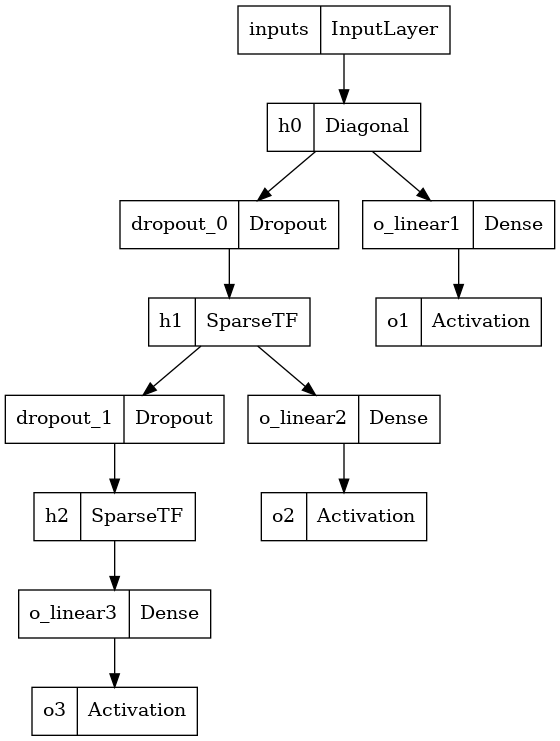

In [9]:
tf.keras.utils.plot_model(pnet_mod)

In [10]:
pnet_mod.fit(
    x_train, y_train,
    validation_data=(x_validate_, y_validate_),
    epochs=20,
    batch_size=10,
    verbose=0
)

input dimensions (None, 27162)
input dimensions (None, 27162)
input dimensions (None, 27162)


In [11]:
# export weights and bias
pnet_mod.save("pnet_tf_mod.h5")
import pickle
weight_dict = {l.name: l.get_weights() for l in pnet_mod.layers}
pickle.dump(weight_dict, open("pnet_tf_weights.pkl", "wb"))

In [12]:
pnet_mod.load_weights('pnet_tf_mod.h5')

In [13]:
layer_dict = {l.name:l for l in pnet_mod.layers}
layer_model = tf.keras.Model(inputs=pnet_mod.inputs, 
                             outputs=[layer_dict['h0'].output, layer_dict['h1'].output, layer_dict['h2'].output, layer_dict['o_linear3'].output])

In [14]:
y_hat = pnet_mod.predict(x_test_)
print([y.shape for y in y_hat])

input dimensions (None, 27162)
4/4 [==============================] - 0s 6ms/step
[(102, 1), (102, 1), (102, 1)]


In [15]:
ys = y_test_.flatten()
outs = y_hat[-1]

fpr_valid, tpr_valid, _ = roc_curve(ys, outs)
test_auc = auc(fpr_valid, tpr_valid)

print('accuracy', accuracy_score(ys, outs>0.5))
print('auc', test_auc)
print('aupr', average_precision_score(ys, outs))
print('f1', f1_score(ys, outs>0.5))
print('precision', precision_score(ys, outs>0.5))
print('recall', recall_score(ys, outs>0.5))

accuracy 0.8921568627450981
auc 0.9563148788927335
aupr 0.922809400415429
f1 0.8358208955223881
precision 0.8484848484848485
recall 0.8235294117647058


In [16]:
layer_dict = {x.name:x for x in pnet_mod.layers}
explain_mod = tf.keras.models.Model(
    inputs=pnet_mod.inputs,
    outputs=[layer_dict['h0'].output, layer_dict['h1'].output, layer_dict['h2'].output, layer_dict['o_linear3'].output]
)

In [17]:
reactome = ReactomeNetwork()
pathway_names = reactome.reactome.pathway_names.copy()
pathway_names.index = pathway_names['reactome_id']
pathway_names['pathway_name'] = pathway_names['pathway_name'].str.replace(' ','_').str.replace('-','_')

In [18]:
data_for_pysr = explain_mod.predict(x_train)
print(len(data_for_pysr))

input dimensions (None, 27162)
26/26 [==============================] - 0s 4ms/step
4


In [19]:
h0 = pd.DataFrame(data_for_pysr[0], columns=reactome_map[0].index)
h1 = pd.DataFrame(data_for_pysr[1], columns=pathway_names.loc[reactome_map[1].index]['pathway_name'])
h2 = pd.DataFrame(data_for_pysr[2], columns=pathway_names.loc[reactome_map[2].index]['pathway_name'])
out = pd.DataFrame(data_for_pysr[3], columns=['out'])

In [20]:
h1 = (h1-h1.mean())/(h1.std())

In [21]:
tmp = h1.join(out)
tmp_corr = tmp.corr()['out'].abs().sort_values(ascending=False).drop('out')
tmp_corr.head(20)

Post_translational_protein_modification         0.947029
RNA_Polymerase_II_Transcription                 0.931106
Cellular_responses_to_stress                    0.806623
Signaling_by_Rho_GTPases                        0.792823
Innate_Immune_System                            0.788090
Adaptive_Immune_System                          0.772831
Metabolism_of_lipids                            0.745028
Cytokine_Signaling_in_Immune_system             0.729845
Membrane_Trafficking                            0.722412
Intracellular_signaling_by_second_messengers    0.704585
Signaling_by_GPCR                               0.694671
Axon_guidance                                   0.685455
Signaling_by_Receptor_Tyrosine_Kinases          0.653207
Diseases_of_signal_transduction                 0.638829
Infectious_disease                              0.622563
Signaling_by_WNT                                0.609308
Signaling_by_NOTCH                              0.607333
Death_Receptor_Signalling      

In [22]:
tmp[tmp_corr.head(20).index].corr().round(3)

,Post_translational_protein_modification,RNA_Polymerase_II_Transcription,Cellular_responses_to_stress,Signaling_by_Rho_GTPases,Innate_Immune_System,Adaptive_Immune_System,Metabolism_of_lipids,Cytokine_Signaling_in_Immune_system,Membrane_Trafficking,Intracellular_signaling_by_second_messengers,Signaling_by_GPCR,Axon_guidance,Signaling_by_Receptor_Tyrosine_Kinases,Diseases_of_signal_transduction,Infectious_disease,Signaling_by_WNT,Signaling_by_NOTCH,Death_Receptor_Signalling,Transmission_across_Chemical_Synapses,Cell_Cycle_Checkpoints
Post_translational_protein_modification,1.000,-0.902,-0.844,-0.822,-0.722,-0.687,0.658,0.605,0.683,-0.637,-0.610,0.599,-0.532,-0.550,-0.527,0.507,0.544,-0.477,0.477,-0.528
RNA_Polymerase_II_Transcription,-0.902,1.000,0.842,0.805,0.638,0.672,-0.634,-0.578,-0.569,0.667,0.544,-0.574,0.515,0.579,0.463,-0.521,-0.554,0.438,-0.462,0.506
Cellular_responses_to_stress,-0.844,0.842,1.000,0.907,0.497,0.497,-0.441,-0.467,-0.421,0.502,0.450,-0.398,0.334,0.378,0.333,-0.368,-0.468,0.350,-0.350,0.489
Signaling_by_Rho_GTPases,-0.822,0.805,0.907,1.000,0.523,0.486,-0.474,-0.451,-0.471,0.415,0.514,-0.421,0.403,0.358,0.391,-0.362,-0.352,0.502,-0.336,0.314
Innate_Immune_System,-0.722,0.638,0.497,0.523,1.000,0.710,-0.621,-0.599,-0.758,0.492,0.634,-0.726,0.663,0.547,0.636,-0.585,-0.478,0.580,-0.564,0.407
Adaptive_Immune_System,-0.687,0.672,0.497,0.486,0.710,1.000,-0.642,-0.579,-0.677,0.665,0.634,-0.607,0.596,0.529,0.586,-0.534,-0.456,0.570,-0.620,0.398
Metabolism_of_lipids,0.658,-0.634,-0.441,-0.474,-0.621,-0.642,1.000,0.626,0.630,-0.577,-0.606,0.578,-0.537,-0.476,-0.506,0.479,0.416,-0.487,0.452,-0.409
Cytokine_Signaling_in_Immune_system,0.605,-0.578,-0.467,-0.451,-0.599,-0.579,0.626,1.000,0.570,-0.566,-0.589,0.509,-0.470,-0.397,-0.538,0.457,0.593,-0.557,0.522,-0.583
Membrane_Trafficking,0.683,-0.569,-0.421,-0.471,-0.758,-0.677,0.630,0.570,1.000,-0.424,-0.647,0.703,-0.623,-0.461,-0.687,0.513,0.391,-0.545,0.547,-0.383
Intracellular_signaling_by_second_messengers,-0.637,0.667,0.502,0.415,0.492,0.665,-0.577,-0.566,-0.424,1.000,0.437,-0.434,0.514,0.534,0.389,-0.454,-0.620,0.373,-0.459,0.628


In [23]:
# Dataset
if enable_run_pysr:
    X_for_pysr = tmp[tmp_corr.head(20).index]
    y_for_pysr = data_for_pysr[3]

    default_pysr_params = dict(
        populations=30,
        procs=4,
        model_selection="best",
    )


In [24]:
# Learn equations
if enable_run_pysr:
    model = pysr.PySRRegressor(
            niterations=30,
            binary_operators=["plus", "sub", "mult", "div", "greater"],
            unary_operators=["neg", "square"],
            **default_pysr_params)

    model.fit(X_for_pysr, y_for_pysr)

In [25]:
if enable_run_pysr:
    model.equations_.sort_values("score", ascending=False)[['complexity', 'loss', 'score', 'equation']]

In [26]:
if enable_run_pysr:
    model.sympy(9)

In [27]:
if enable_run_pysr:
    model.sympy()

In [28]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Wed Oct 12 2022

Python implementation: CPython
Python version       : 3.9.13
IPython version      : 8.4.0

torch          : 1.11.0
torch_geometric: 2.0.4
pysr           : 0.11.0
tensorflow     : 2.10.0
cancernet      : 0.0.5
numpy          : 1.23.3
pandas         : 1.4.4

Watermark: 2.3.1



# To Be Discarded

.. For checking intermediate layers with PyTorch P-Net implementation

In [29]:
tf_model = pnet_mod
layer_dict = {x.name:x for x in tf_model.layers}
layer_mod = tf.keras.models.Model(
    inputs=tf_model.inputs,
    outputs=[layer_dict['h0'].output, layer_dict['h1'].output, layer_dict['h2'].output, layer_dict['o_linear3'].output]
)

In [30]:
# check input data as well
idx = np.array([196])
x_train[idx,].sum(), np.where(x_train[idx,])[1]

(30.0,
 array([   75,   754,  1812,  1848,  3249,  3270,  4458,  4503,  4671,
         7949,  7952,  9128,  9195, 11208, 11370, 12054, 12148, 12414,
        12922, 13053, 14958, 15009, 17187, 18129, 18689, 21698, 22671,
        24176, 24179, 25485]))

In [31]:
tf_out = [np.round(x, 3) for x in layer_mod.predict(x_train[idx,])]
tf_out, \
tf_model.predict(x_train[idx,])

input dimensions (None, 27162)
1/1 [==============================] - 0s 21ms/step


([array([[ 0.001, -0.   ,  0.   , ...,  0.   ,  0.   , -0.   ]],
        dtype=float32),
  array([[ 0.049, -0.022,  0.017, -0.021,  0.016, -0.   ,  0.04 ,  0.145,
           0.034, -0.027,  0.029,  0.031,  0.021, -0.022,  0.021, -0.003,
           0.289, -0.017,  0.027, -0.039, -0.031, -0.004, -0.039, -0.026,
          -0.03 ,  0.03 , -0.007,  0.026, -0.013,  0.104, -0.077, -0.022,
           0.045,  0.249,  0.024,  0.006,  0.297,  0.336, -0.022, -0.037,
          -0.001,  0.008,  0.008, -0.006, -0.001, -0.08 , -0.1  ,  0.344,
          -0.044,  0.011, -0.019,  0.009, -0.025, -0.02 , -0.042, -0.284,
          -0.027,  0.036, -0.007, -0.023, -0.012, -0.014, -0.031,  0.028,
           0.021,  0.011, -0.02 , -0.03 , -0.017,  0.007,  0.035, -0.033,
          -0.038, -0.027,  0.008, -0.031, -0.021, -0.034, -0.03 , -0.017,
           0.002,  0.03 , -0.021,  0.302, -0.031,  0.047, -0.026,  0.018,
          -0.018,  0.061, -0.012,  0.022,  0.037, -0.024, -0.003,  0.01 ,
          -0.053,  0.02

In [32]:
y_hat = tf_model.predict(x_test_)
print([y.shape for y in y_hat])
ys = y_test_.flatten()
outs = y_hat[-1]

fpr_valid, tpr_valid, _ = roc_curve(ys, outs)
test_auc = auc(fpr_valid, tpr_valid)

print('accuracy', accuracy_score(ys, outs>0.5))
print('auc', test_auc)
print('aupr', average_precision_score(ys, outs))
print('f1', f1_score(ys, outs>0.5))
print('precision', precision_score(ys, outs>0.5))
print('recall', recall_score(ys, outs>0.5))

4/4 [==============================] - 0s 5ms/step
[(102, 1), (102, 1), (102, 1)]
accuracy 0.8921568627450981
auc 0.9563148788927335
aupr 0.922809400415429
f1 0.8358208955223881
precision 0.8484848484848485
recall 0.8235294117647058


should be 
```
array([[   0,  122],
       [   1,    6],
       [   1,   41],
       ...,
       [9048,   33],
       [9048,  104],
       [9053,   54]])
```

In [33]:
tf_model.layers[3].nonzero_ind

array([[   0,  122],
       [   1,    6],
       [   1,   41],
       ...,
       [9048,   33],
       [9048,  104],
       [9053,   54]])

should be
```
array([[24,  3],
       [25, 11],
       [26, 24],
       [27,  3],
       [28,  7],
       [29, 10],
       [30, 12],
       [31,  2],
       [32,  3],
       [33,  7]])
```

In [34]:
tf_model.layers[5].nonzero_ind[25:35]

array([[24,  3],
       [25, 11],
       [26, 24],
       [27,  3],
       [28,  7],
       [29, 10],
       [30, 12],
       [31,  2],
       [32,  3],
       [33,  7]])